# MNIST Tutorial

**This tutorial was tested with the version `0.0.1-beta0` of NeuroTorch.**

In this tutorial we will be learning how to use NeuroTorch to train a neural network to recognize handwritten digits.

## Setup

You can now install the dependencies by running the following commands:

In [ ]:
!pip install -r mnist_requirements.txt
!pip install norse

If you have a cuda device and want to use it for this tutorial (it is recommended to do so), you can uninstall pytorch with `pip uninstall torch` and re-install it with the right cuda version by generating a command with [PyTorch GetStarted](https://pytorch.org/get-started/locally/) web page.

After setting up the virtual environment, we will need to import the necessary packages.

In [1]:
import os
import pprint
from collections import OrderedDict

import psutil
import torch
from torchvision.transforms import Compose
import norse
from pythonbasictools.device import log_device_setup, DeepLib
from pythonbasictools.logging import logs_file_setup

from tutorials.mnist.dataset import get_dataloaders, DatasetId
import neurotorch as nt
from neurotorch import Dimension, DimensionProperty
from neurotorch.callbacks import CheckpointManager, LoadCheckpointMode
from neurotorch.metrics import ClassificationMetrics
from neurotorch.trainers import ClassificationTrainer
from neurotorch.transforms.spikes_encoders import SpyLIFEncoder

In [2]:
logs_file_setup("mnist_tutorial", add_stdout=False)
log_device_setup(deepLib=DeepLib.Pytorch)
if torch.cuda.is_available():
	torch.cuda.set_per_process_memory_fraction(0.8)

INFO:root:Logs file at: .//logs/logs-01-12-2022/mnist_tutorial-16699306328796575.log

INFO:root:__Python VERSION: 3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]
INFO:root:Number of available cores: 12.
INFO:root:Number of available logical processors: 24.
INFO:root:__pyTorch VERSION:1.12.1+cu116
INFO:root:__CUDA VERSION:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0

INFO:root:__nvidia-smi: Not Found
INFO:root:__CUDNN VERSION:8302
INFO:root:__Number CUDA Devices:1
INFO:root:
-------------------------
DEVICE: cuda
-------------------------

INFO:root:NVIDIA GeForce RTX 3070
INFO:root:Memory Usage:
INFO:root:Allocated: 0.0 GB
INFO:root:Cached:   0.0 GB
INFO:root:Memory summary: 
|===========================================================================|
|                  PyT

## Initialization

It's the time to defined our training and networks parameters. In the following,

- the number of iteration is the number of time the trainer will pass through the entire training dataset;
- the batch size is the number of samples that will be loaded at the same time for each forward and backward pass;
- the learning rate is the learning rate used by the optimizer;
- the number of steps is the number of euler integration steps performed by the model during each forward and backward pass;
- the number of hidden neurons is the number of neurons that will be used in the hidden layer of the model;
- dt is the time step of the euler integration;

In [3]:
dataset_id = DatasetId.MNIST

# Training parameters
n_iterations = 30
batch_size = 1024
learning_rate = 1e-3

# Network parameters
n_steps = 8
n_hidden_neurons = 128
dt = 1e-3

Here we're initializing a callback of the trainer used to save the network during the training.

In [4]:
checkpoint_folder = f"./checkpoints/{dataset_id.name}"
checkpoint_manager = CheckpointManager(checkpoint_folder, save_best_only=True)

NeuroTorch is a library that allows to build bio-like networks, that is, they are in general recurrent neural networks. In this task we are classifying images, so we must transform the input images into times series of values. In our case, we are using spiking neural network to perform the classification, so we will transform the input images into spikes trains. The used transform in this tutorial is the ConstantCurrentLIFEncoder from the [norse](https://github.com/norse/norse) library.

In [5]:
# input_transform = Compose([torch.nn.Flatten(start_dim=1), norse.torch.ConstantCurrentLIFEncoder(seq_length=n_steps, dt=dt), Lambda(lambda x: x.permute(1, 0, 2))])
input_transform = Compose([torch.nn.Flatten(start_dim=2), SpyLIFEncoder(n_steps=n_steps, n_units=28*28)])

It is time to load the dataloaders. The dataloader is an object used to the data from a given dataset. In our case we will load the MNIST or the FASHION-MNIST dataset. To change the dataset, just change the value of the variable `dataset_id` for `DatasetId.MNIST` or `DatasetId.FASHION_MNIST` in the cell below.


Here is an exemple of the MNIST dataset:
<p align="center"> <img width="1200" height="500" src="../../images/mnist/MnistExamples.png"> </p>

And an exemple of the Fashion-MNIST dataset:
<p align="center"> <img width="1200" height="500" src="../../images/mnist/fashion-mnist-sprite.png"> </p>

In [6]:
dataloaders = get_dataloaders(
	dataset_id=dataset_id,
	batch_size=batch_size,
	train_val_split_ratio=0.95,
	nb_workers=max(0, min(2, psutil.cpu_count(logical=False))),
	pin_memory=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/datasets/torch/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/datasets/torch/mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/datasets/torch/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/datasets/torch/mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/datasets/torch/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/datasets/torch/mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/datasets/torch/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/datasets/torch/mnist\MNIST\raw



We can finally define our model. The sequential model is a neural network that is composed of a list of layers. The list of layers is ordered and the first layer is the input layer. The last layer is the output layer. The sequential model can be found in the subpackage `neurotorch.modules`. Note that we can specify the input transform that will be applied to the input data before the forward pass through the list of layers. If the transformation is computationally expensive, it is recommended to put it in the dataloaders instead of the model for the training. Usually the input transform in the model is used when the model is used for inference.

In [7]:
network = nt.SequentialRNN(
	input_transform=input_transform,
	layers=[
		nt.LIFLayer(
			input_size=[Dimension(None, DimensionProperty.TIME), Dimension(28*28, DimensionProperty.NONE)],
			use_recurrent_connection=False,
			output_size=n_hidden_neurons,
			dt=dt,
		),
		nt.SpyLILayer(dt=dt, output_size=10),
	],
	name=f"{dataset_id.name}_network",
	checkpoint_folder=checkpoint_folder,
	hh_memory_size=1,
)

After the instantiation of the model, we have to build it, so it can infer the missing sizes of the layers in the model and create the tensors that will be used during the training.

In [8]:
network.build()
print(network)

SequentialRNN(
  (_to_device_transform): ToDevice(cuda, async=True)
  (input_layers): ModuleDict(
    (input_0): LIFLayer<input_0>(784->128)@cuda
  )
  (hidden_layers): ModuleList()
  (output_layers): ModuleDict(
    (output_0): SpyLILayer<output_0>(128->10)@cuda
  )
  (_memory_device_transform): ToDevice(cuda, async=True)
  (input_transform): ModuleDict(
    (input_0): Sequential(
      (0): CallableToModuleWrapper(Compose(
          Flatten(start_dim=2, end_dim=-1)
          SpyLIFEncoder(
        (const_transform): ConstantValuesTransform(n_steps=8)
        (spikes_layer): SpyLIFLayer<encoder>(784->784)@cuda
      )
      ))
      (1): ToDevice(cuda, async=True)
    )
  )
  (output_transform): ModuleDict(
    (output_0): IdentityTransform()
  )
)


## Training

In the next cell, we create the trainer that will be used to trained our network. They are several types of trainers that can be found in the subpackage `neurotorch.trainers` like the `ClassificationTrainer`, the `RegressionTrainer` or the `PPOTrainer`. In this tutorial, we will use the `ClassificationTrainer` because we are trying to classify some images. Note that the callbacks are some object that will be called during the training. They are found in the subpackage `neurotorch.callbacks` like the `CheckpointManager`.

In [9]:
callbacks = [
	checkpoint_manager,
	nt.BPTT(
		optimizer=torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=0.0),
		criterion=torch.nn.NLLLoss(),
	),
]

In [10]:
trainer = ClassificationTrainer(
	model=network,
	callbacks=callbacks,
	verbose=True,
)
print(trainer)

ClassificationTrainer(
	model=SequentialRNN(
  (_to_device_transform): ToDevice(cuda, async=True)
  (input_layers): ModuleDict(
    (input_0): LIFLayer<input_0>(784->128)@cuda
  )
  (hidden_layers): ModuleList()
  (output_layers): ModuleDict(
    (output_0): SpyLILayer<output_0>(128->10)@cuda
  )
  (_memory_device_transform): ToDevice(cuda, async=True)
  (input_transform): ModuleDict(
    (input_0): Sequential(
      (0): CallableToModuleWrapper(Compose(
          Flatten(start_dim=2, end_dim=-1)
          SpyLIFEncoder(
        (const_transform): ConstantValuesTransform(n_steps=8)
        (spikes_layer): SpyLIFLayer<encoder>(784->784)@cuda
      )
      ))
      (1): ToDevice(cuda, async=True)
    )
  )
  (output_transform): ModuleDict(
    (output_0): IdentityTransform()
  )
), 
	predict_method=get_prediction_log_proba, 
	callbacks=CallbacksList(
	TrainingHistory<0>: (priority=0, save_state=True, load_state=True, , n=0, metrics=[]), 
	BPTT<0>: (priority=50, save_state=True, load_stat

The training will start! Let's see how our simple network will perform on this task.

Note: the argument `force_overwrite` is used to overwrite the existing checkpoint if it exists and the argument `load_checkpoint_mode` if the model will be loaded from the last checkpoint (`LoadCheckpointMode.LAST_ITR`) or from the best checkpoint (`LoadCheckpointMode.BEST_ITR`). The loading mode is really useful when you want to stop the training and restart it later.

In [11]:
training_history = trainer.train(
	dataloaders["train"],
	dataloaders["val"],
	n_iterations=n_iterations,
	load_checkpoint_mode=LoadCheckpointMode.LAST_ITR,
	# force_overwrite=True,
)

Training:   0%|          | 0/30 [00:00<?, ?itr/s]

The training is finished! Let's see how our network learned over the iterations.

Note: the next graphs are really useful to see if the model overfit or underfit the data over the iterations. It's why you can use the callback `TrainingHistoryVisualizationCallback` to see those graphs in real time.

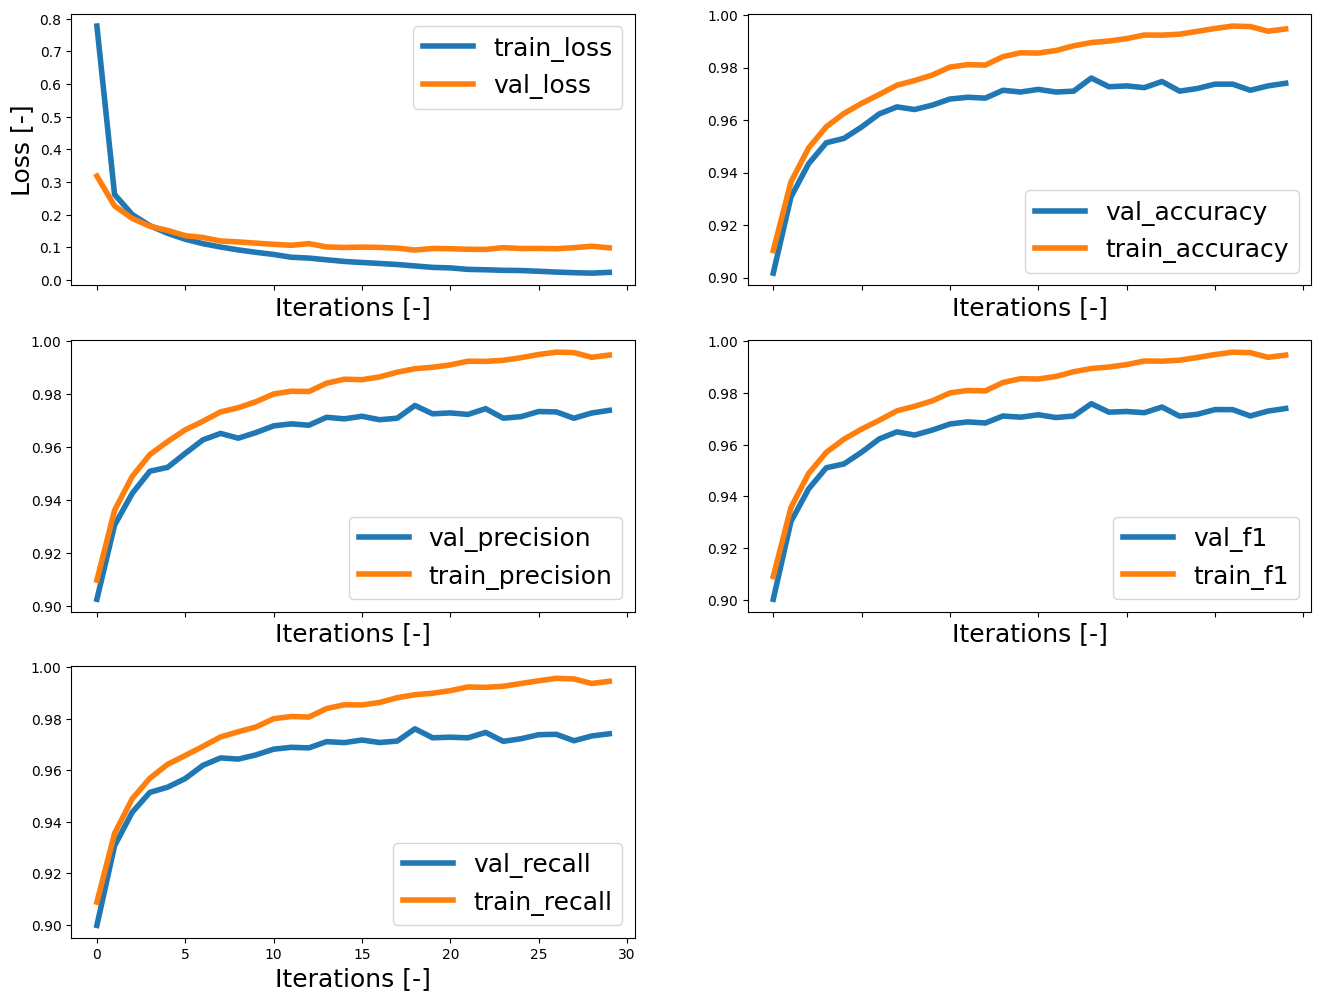

(<Figure size 1600x1200 with 6 Axes>,
 {'losses': <AxesSubplot: xlabel='Iterations [-]', ylabel='Loss [-]'>,
  'val_accuracy': <AxesSubplot: xlabel='Iterations [-]'>,
  'train_accuracy': <AxesSubplot: xlabel='Iterations [-]'>,
  'val_precision': <AxesSubplot: xlabel='Iterations [-]'>,
  'train_precision': <AxesSubplot: xlabel='Iterations [-]'>,
  'val_f1': <AxesSubplot: xlabel='Iterations [-]'>,
  'train_f1': <AxesSubplot: xlabel='Iterations [-]'>,
  'val_recall': <AxesSubplot: xlabel='Iterations [-]'>,
  'train_recall': <AxesSubplot: xlabel='Iterations [-]'>},
 {'train_loss': <matplotlib.lines.Line2D at 0x127082738e0>,
  'val_loss': <matplotlib.lines.Line2D at 0x12708273bb0>,
  'val_accuracy': <matplotlib.lines.Line2D at 0x127082abfa0>,
  'train_accuracy': <matplotlib.lines.Line2D at 0x12708297b80>,
  'val_precision': <matplotlib.lines.Line2D at 0x127053eb220>,
  'train_precision': <matplotlib.lines.Line2D at 0x127053eb4f0>,
  'val_f1': <matplotlib.lines.Line2D at 0x127053c75e0>,
  't

In [12]:
training_history.plot(show=True)

We can load the model at the best or the last iteration for the testing phase.

In [13]:
network.load_checkpoint(checkpoint_manager.checkpoints_meta_path, LoadCheckpointMode.BEST_ITR, verbose=True)

INFO:root:Loading checkpoint from ./checkpoints/MNIST/network-itr18.pth


{'itr': 18,
 'model_state_dict': OrderedDict([('input_layers.input_0.alpha',
               tensor(0.9048, device='cuda:0')),
              ('input_layers.input_0.threshold', tensor(1., device='cuda:0')),
              ('input_layers.input_0.gamma', tensor(100., device='cuda:0')),
              ('input_layers.input_0._forward_weights',
               tensor([[ 0.0643, -0.0076, -0.1288,  ...,  0.0792,  0.0311, -0.0320],
                       [ 0.0328, -0.0200,  0.0046,  ..., -0.0106,  0.0137,  0.0445],
                       [-0.0122, -0.0552,  0.0564,  ...,  0.0350,  0.0412, -0.0277],
                       ...,
                       [ 0.0762, -0.0123,  0.0226,  ...,  0.0053, -0.0057,  0.0012],
                       [ 0.0245,  0.0447, -0.0536,  ...,  0.0103, -0.0571,  0.0248],
                       [ 0.0304,  0.0210, -0.0279,  ...,  0.0609, -0.0059,  0.0363]],
                      device='cuda:0')),
              ('output_layers.output_0.alpha',
               tensor(0.8187, devic

We can now see how our network perform on the test dataset.

In [14]:
accuracies={
	k: ClassificationMetrics.accuracy(network, dataloaders[k], verbose=True, desc=f"{k}_accuracy")
	for k in dataloaders
}
pprint.pprint(accuracies)

train_accuracy:   0%|          | 0/56 [00:00<?, ?it/s]

val_accuracy:   0%|          | 0/3 [00:00<?, ?it/s]

test_accuracy:   0%|          | 0/10 [00:00<?, ?it/s]

{'test': 0.9711, 'train': 0.9895087719298246, 'val': 0.976}


Let's see the results on other popular classification metrics.

In [15]:
precisions={
	k: ClassificationMetrics.precision(network, dataloaders[k], verbose=True, desc=f"{k}_precision")
	for k in dataloaders
},
recalls={
	k: ClassificationMetrics.recall(network, dataloaders[k], verbose=True, desc=f"{k}_recall")
	for k in dataloaders
},
f1s={
	k: ClassificationMetrics.f1(network, dataloaders[k], verbose=True, desc=f"{k}_f1")
	for k in dataloaders
}

train_precision:   0%|          | 0/56 [00:00<?, ?it/s]

val_precision:   0%|          | 0/3 [00:00<?, ?it/s]

test_precision:   0%|          | 0/10 [00:00<?, ?it/s]

train_recall:   0%|          | 0/56 [00:00<?, ?it/s]

val_recall:   0%|          | 0/3 [00:00<?, ?it/s]

test_recall:   0%|          | 0/10 [00:00<?, ?it/s]

train_f1:   0%|          | 0/56 [00:00<?, ?it/s]

val_f1:   0%|          | 0/3 [00:00<?, ?it/s]

test_f1:   0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
results = OrderedDict(dict(
	network=network,
	accuracies=accuracies,
	precisions=precisions,
	recalls=recalls,
	f1s=f1s,
))

In [17]:
pprint.pprint(results, indent=4)

OrderedDict([   (   'network',
                    SequentialRNN(
  (_to_device_transform): ToDevice(cuda, async=True)
  (input_layers): ModuleDict(
    (input_0): LIFLayer<input_0>(784->128)@cuda
  )
  (hidden_layers): ModuleList()
  (output_layers): ModuleDict(
    (output_0): SpyLILayer<output_0>(128->10)@cuda
  )
  (_memory_device_transform): ToDevice(cuda, async=True)
  (input_transform): ModuleDict(
    (input_0): Sequential(
      (0): CallableToModuleWrapper(Compose(
          Flatten(start_dim=2, end_dim=-1)
          SpyLIFEncoder(
        (const_transform): ConstantValuesTransform(n_steps=8)
        (spikes_layer): SpyLIFLayer<encoder>(784->784)@cuda
      )
      ))
      (1): ToDevice(cuda, async=True)
    )
  )
  (output_transform): ModuleDict(
    (output_0): IdentityTransform()
  )
)),
                (   'accuracies',
                    {   'test': 0.9711,
                        'train': 0.9895087719298246,
                        'val': 0.976}),
                (   

This is the end of the tutorial!

# Conclusion

NeuroTorch is a library that allows you to easily build neural networks and train them. Moreover, it allows you to do image classification using dynamics from neurosciences.